# Unveiling Character Dynamics: A Quantitative Exploration of Movie Narratives

Welcome to our project notebook for Milestone P2! 

Throughout this phase, our team has dedicated efforts to enhance our project proposal and initiate initial examinations, laying the groundwork for an effective expedition into data exploration and analysis.

# Imports

In [77]:
import ast
import re
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from helper import *

%matplotlib inline
plt.rcParams['font.family'] = 'Times New Roman'

# Section I: Movie Metadata

The movie metadata set includes movie box office revenue, genre, release date, runtime, and language.

In [78]:
# Load Data
movies = pd.read_csv('../data/movie.metadata.tsv', sep='\t', header=None)
movies.columns = [
    'wikipedia_movie_id',
    'freebase_movie_id',
    'movie_name',
    'movie_release_date',
    'movie_box_office_revenue',
    'movie_runtime',
    'movie_languages',
    'movie_countries',
    'movie_genres'
]
movies.head()

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [89]:
# Print summary information
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   wikipedia_movie_id        81741 non-null  int64  
 1   freebase_movie_id         81741 non-null  object 
 2   movie_name                81741 non-null  object 
 3   movie_release_date        74839 non-null  object 
 4   movie_box_office_revenue  8401 non-null   float64
 5   movie_runtime             61291 non-null  float64
 6   movie_languages           81741 non-null  object 
 7   movie_countries           81741 non-null  object 
 8   movie_genres              81741 non-null  object 
 9   year                      74839 non-null  float64
 10  movie_languages_cleaned   81741 non-null  object 
 11  movie_languages_num       81741 non-null  int64  
 12  movie_countries_cleaned   81741 non-null  object 
 13  movie_genres_cleaned      81741 non-null  object 
dtypes: flo

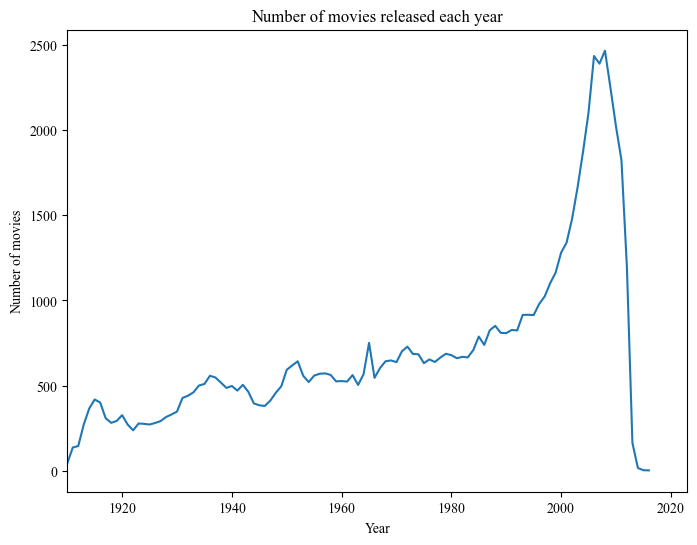

In [79]:
# find the year of the movie
movies['year'] = movies['movie_release_date'].str.extract('(\d{4})', expand=False)
movies['year'] = pd.to_numeric(movies['year'], downcast='integer')

# plot the number of movies released each year
movies_per_year = movies.groupby('year')['movie_name'].count()

plt.figure(figsize=(8, 6))
plt.title('Number of movies released each year')
plt.ylabel('Number of movies')
plt.xlabel('Year')
plt.xlim(1910, 2023)
plt.plot(movies_per_year)
plt.show()

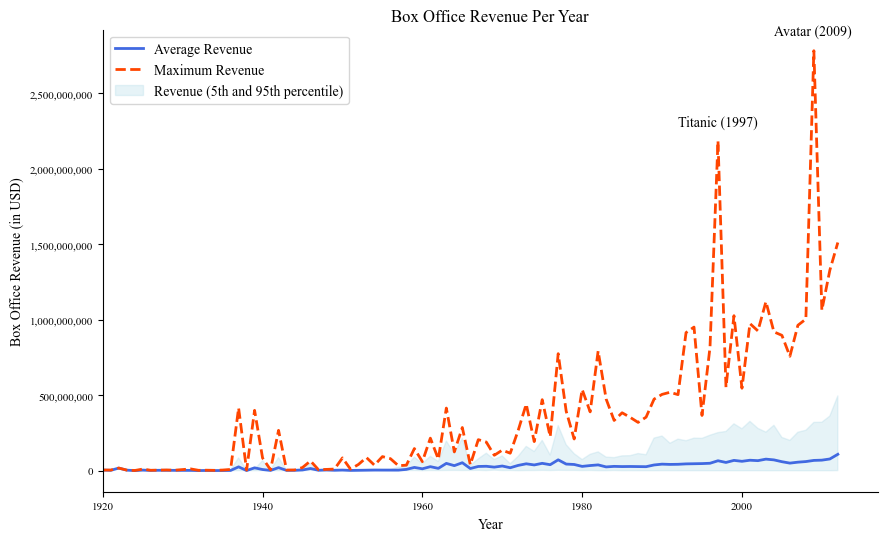

In [80]:
# average box office revenue per year
movies['movie_box_office_revenue'] = pd.to_numeric(movies['movie_box_office_revenue'], errors='coerce')
mean_revenue_per_year = movies.groupby('year')['movie_box_office_revenue'].mean()
max_revenue_per_year = movies.groupby('year')['movie_box_office_revenue'].max()
revenue_per_year_25 = movies.groupby('year')['movie_box_office_revenue'].quantile(0.05)
revenue_per_year_75 = movies.groupby('year')['movie_box_office_revenue'].quantile(0.95)

# find the name of the two movies with the highest revenue
top1_movie_idx = movies[movies['movie_box_office_revenue'] == max_revenue_per_year.max()].index[0]
top2_movie_idx = movies[movies['movie_box_office_revenue'] == max_revenue_per_year.sort_values(ascending=False).iloc[1]].index[0]


plt.figure(figsize=(10, 6))
plt.title('Box Office Revenue Per Year', fontsize=12)
plt.ylabel('Box Office Revenue (in USD)', fontsize=10)
plt.xlabel('Year', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(1920, 2017)

plt.plot(mean_revenue_per_year, color='royalblue', linestyle='-', linewidth=2, label='Average Revenue')
plt.plot(max_revenue_per_year, color='orangered', linestyle='--', linewidth=2, label='Maximum Revenue')

# Shaded area for 5th and 95th percentile
plt.fill_between(mean_revenue_per_year.index, 
                revenue_per_year_25,
                revenue_per_year_75, 
                color='lightblue', alpha=0.3,
                label='Revenue (5th and 95th percentile)')

# Annotate the two movies with the highest revenue
plt.annotate(movies['movie_name'][top1_movie_idx]+' ('+str(int(movies['year'][top1_movie_idx]))+')',
            xy=(movies['year'][top1_movie_idx], movies['movie_box_office_revenue'][top1_movie_idx]),
            xytext=(movies['year'][top1_movie_idx]-5, movies['movie_box_office_revenue'][top1_movie_idx]+1e8),
            fontsize=10)
plt.annotate(movies['movie_name'][top2_movie_idx]+' ('+str(int(movies['year'][top2_movie_idx]))+')',
            xy=(movies['year'][top2_movie_idx], movies['movie_box_office_revenue'][top2_movie_idx]),
            xytext=(movies['year'][top2_movie_idx]-5, movies['movie_box_office_revenue'][top2_movie_idx]+1e8),
            fontsize=10)

# Format y-axis as currency
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.gca().xaxis.grid(False)  # Disable the vertical grid lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)

plt.legend(loc='upper left', fontsize=10)

plt.show()


There is an outlier which doesn't show in this plot:  Zero Tolerance ( 1995 ), which has a runtime of  1079281.0 minutes !


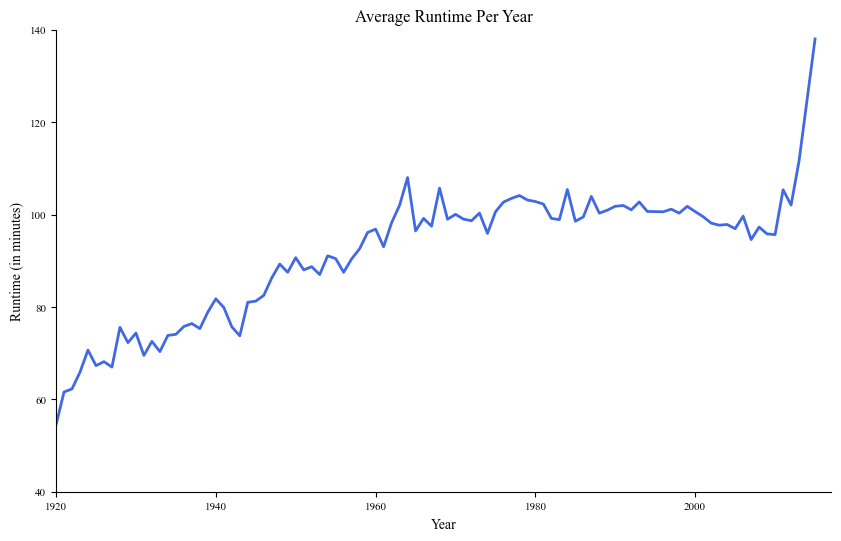

In [81]:
# average runtime per year
movies['movie_runtime'] = pd.to_numeric(movies['movie_runtime'], errors='coerce')
mean_runtime_per_year = movies.groupby('year')['movie_runtime'].mean()
# drop the outlier
max_mean_runtime_per_year = mean_runtime_per_year.sort_values(ascending=False).iloc[1]
mean_runtime_per_year = mean_runtime_per_year[mean_runtime_per_year < max_mean_runtime_per_year]

outlier_idx = movies[movies['movie_runtime'] == movies['movie_runtime'].max()].index[0]
print('There is an outlier which doesn\'t show in this plot: ',
        movies['movie_name'][outlier_idx], '(',
        str(int(movies['year'][outlier_idx])),
        '), which has a runtime of ',
        movies['movie_runtime'][outlier_idx], 'minutes !')

plt.figure(figsize=(10, 6))
plt.title('Average Runtime Per Year', fontsize=12)
plt.ylabel('Runtime (in minutes)', fontsize=10)
plt.xlabel('Year', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(1920, 2017)
plt.ylim(40, 140)

plt.plot(mean_runtime_per_year, color='royalblue', linestyle='-', linewidth=2, label='Average Runtime')

plt.gca().xaxis.grid(False)  # Disable the vertical grid lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

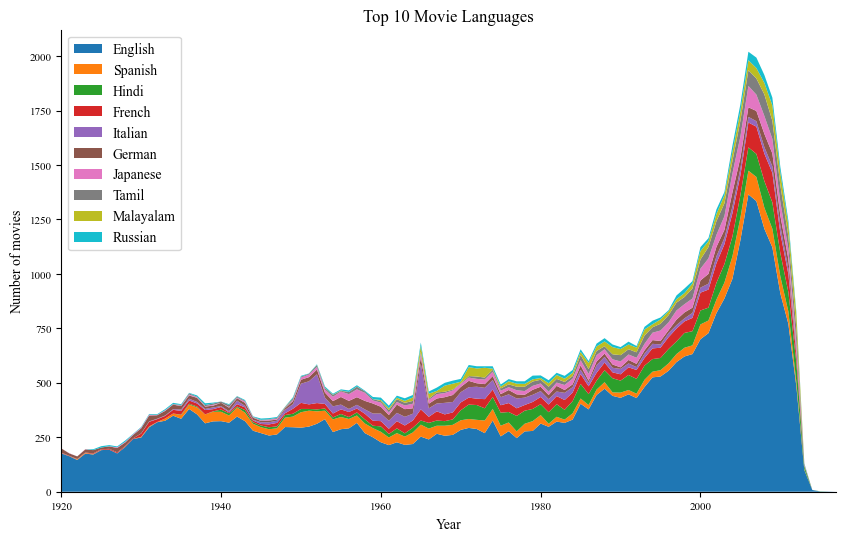

In [82]:
# movie language distribution
query = re.compile(r'"(\w+) Language"')
movies['movie_languages_cleaned'] = movies['movie_languages'].fillna('[]')
movies['movie_languages_cleaned'] = movies['movie_languages'].apply(lambda x: query.findall(x))

movies['movie_languages_num'] = movies['movie_languages_cleaned'].apply(lambda x: len(x) if x != [] else 1)
movie_languages_per_year = {}

for year in range(1920, 2018):
    languages = movies[movies['year'] == year]['movie_languages_cleaned'].sum()
    languages_count = pd.Series(languages).value_counts()
    movie_languages_per_year[year] = languages_count

movie_languages_per_year = pd.DataFrame(movie_languages_per_year).fillna(0).astype(int).transpose()

# plot the top 10 languages
top10_languages = movie_languages_per_year.sum().sort_values(ascending=False).index[:10]
movie_languages_per_year = movie_languages_per_year[top10_languages]

plt.figure(figsize=(10, 6))
plt.title('Top 10 Movie Languages', fontsize=12)
plt.ylabel('Number of movies', fontsize=10)
plt.xlabel('Year', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(1920, 2017)

plt.stackplot(movie_languages_per_year.index,
                movie_languages_per_year.values.T,
                labels=movie_languages_per_year.columns)

plt.gca().xaxis.grid(False)  # Disable the vertical grid lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc='upper left', fontsize=10)

plt.show()

In [84]:
# country distribution
query = re.compile(r': "(.+)"')
movies['movie_countries_cleaned'] = movies['movie_countries'].fillna('[]')
movies['movie_countries_cleaned'] = movies['movie_countries'].apply(lambda x: query.findall(x)[0] if query.findall(x) != [] else '')

# plot the country distribution per year
country_distribution = movies.groupby(['year', 'movie_countries_cleaned']).size().reset_index(name='count')
country_distribution = country_distribution[country_distribution['year'] >= 1920]
country_distribution['year'] = country_distribution['year'].astype(int)

fig = px.choropleth(
    country_distribution, 
    locations="movie_countries_cleaned", 
    locationmode='country names',
    color="count", 
    hover_name="movie_countries_cleaned",
    animation_frame="year",
    range_color=[0, country_distribution['count'].max()],
    title="Movie Production by Country Over Time"
)

fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=False,
    ),
    width=1000,  # Adjust the width
    height=600   # Adjust the height
)

fig.show()

This interactive image cannot be viewed directly from github.

To see it, first make sure that plotly is installed (pip install plotly) in your local environment, then run the file.

![Map](../generated/images/country_distribution_per_year.png)

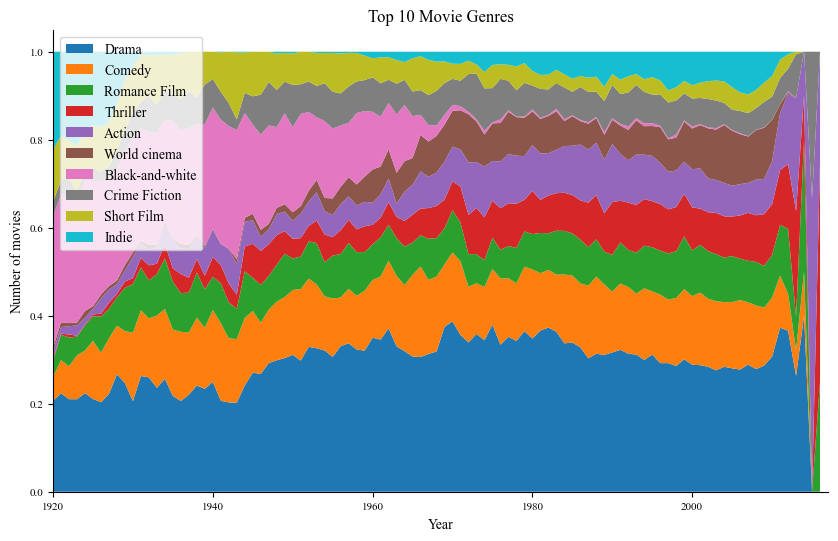

In [85]:
# genre distribution
query = re.compile(r': "(.+?)"')
movies['movie_genres_cleaned'] = movies['movie_genres'].fillna('[]')
movies['movie_genres_cleaned'] = movies['movie_genres'].apply(lambda x: query.findall(x))

movie_genres_per_year = {}
for year in range(1920, 2018):
    genres = movies[movies['year'] == year]['movie_genres_cleaned'].sum()
    genres_count = pd.Series(genres).value_counts()
    movie_genres_per_year[year] = genres_count

movie_genres_per_year = pd.DataFrame(movie_genres_per_year).fillna(0).astype(int).transpose()

# plot the top 10 genres
top10_genres = movie_genres_per_year.sum().sort_values(ascending=False).index[:10]
movie_genres_per_year = movie_genres_per_year[top10_genres]

# change to proportion
movie_genres_per_year = movie_genres_per_year.div(movie_genres_per_year.sum(axis=1), axis=0)

plt.figure(figsize=(10, 6))
plt.title('Top 10 Movie Genres', fontsize=12)
plt.ylabel('Number of movies', fontsize=10)
plt.xlabel('Year', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(1920, 2017)

plt.stackplot(movie_genres_per_year.index,
                movie_genres_per_year.values.T,
                labels=movie_genres_per_year.columns)

plt.gca().xaxis.grid(False)  # Disable the vertical grid lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc='upper left', fontsize=10)

plt.show()



# Section II: Character Metadata

Character Metadata encompasses character names and associated details regarding the actors portraying them, such as gender and estimated age during the movie's release.

In [86]:
characters = pd.read_csv('../data/character.metadata.tsv', sep='\t', header=None)
characters.columns = [
    'wikipedia_movie_id',
    'freebase_movie_id',
    'movie_release_date',
    'character_name',
    'actor_dob',
    'actor_gender',
    'actor_height',
    'actor_ethnicity',
    'actor_name',
    'actor_age',
    'freebase_character_map_1',
    'freebase_character_map_2',
    'freebase_character_map_3'
]
characters.head()

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map_1,freebase_character_map_2,freebase_character_map_3
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [88]:
characters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   wikipedia_movie_id        450669 non-null  int64         
 1   freebase_movie_id         450669 non-null  object        
 2   movie_release_date        273872 non-null  datetime64[ns]
 3   character_name            192794 non-null  object        
 4   actor_dob                 344524 non-null  object        
 5   actor_gender              405060 non-null  object        
 6   actor_height              154824 non-null  float64       
 7   actor_ethnicity           106058 non-null  object        
 8   actor_name                449441 non-null  object        
 9   actor_age                 292556 non-null  float64       
 10  freebase_character_map_1  450669 non-null  object        
 11  freebase_character_map_2  192804 non-null  object        
 12  fr

In [90]:
# Calculate missing data ratio for each column
missing_ratio = characters.isnull().mean()

# Display the missing data ratio for each column
print("Missing Data Ratio for Each Column:")
print(missing_ratio)


# Convert 'movie_release_date' to datetime
characters['movie_release_date'] = pd.to_datetime(characters['movie_release_date'], errors='coerce')

# Summary statistics
#print(characters.describe())

# Visualize actor gender distribution
#sns.countplot(x='actor_gender', data=characters)
#plt.title('Actor Gender Distribution')
#plt.show()


Missing Data Ratio for Each Column:
wikipedia_movie_id          0.000000
freebase_movie_id           0.000000
movie_release_date          0.392299
character_name              0.572205
actor_dob                   0.235528
actor_gender                0.101203
actor_height                0.656457
actor_ethnicity             0.764665
actor_name                  0.002725
actor_age                   0.350841
freebase_character_map_1    0.000000
freebase_character_map_2    0.572183
freebase_character_map_3    0.001808
dtype: float64


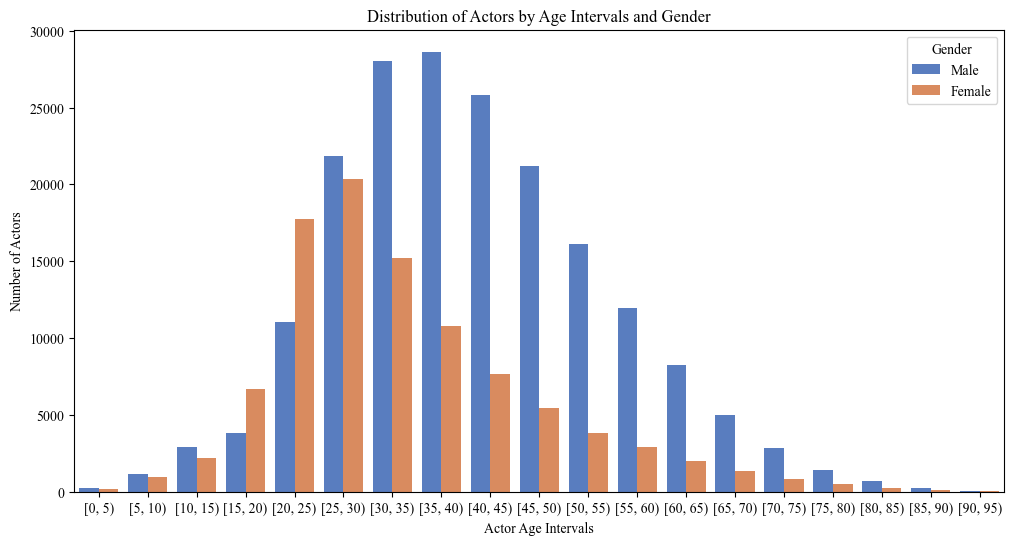

In [91]:
# Drop rows with missing values in 'actor_age' and 'actor_gender' for better visualization
data_for_plot = characters.dropna(subset=['actor_age', 'actor_gender'])

# Create age intervals
age_intervals = pd.cut(data_for_plot['actor_age'], bins=range(0, 100, 5), right=False)

# Set up the figure and axes
plt.figure(figsize=(12, 6))

# Create a countplot for each gender with age intervals of 3
sns.countplot(x=age_intervals, hue='actor_gender', data=data_for_plot, palette='muted', hue_order=['M', 'F'])

# Set labels and title
plt.title('Distribution of Actors by Age Intervals and Gender')
plt.xlabel('Actor Age Intervals')
plt.ylabel('Number of Actors')

# Display the legend
plt.legend(title='Gender', labels=['Male', 'Female'])

# Show the plot
plt.show()


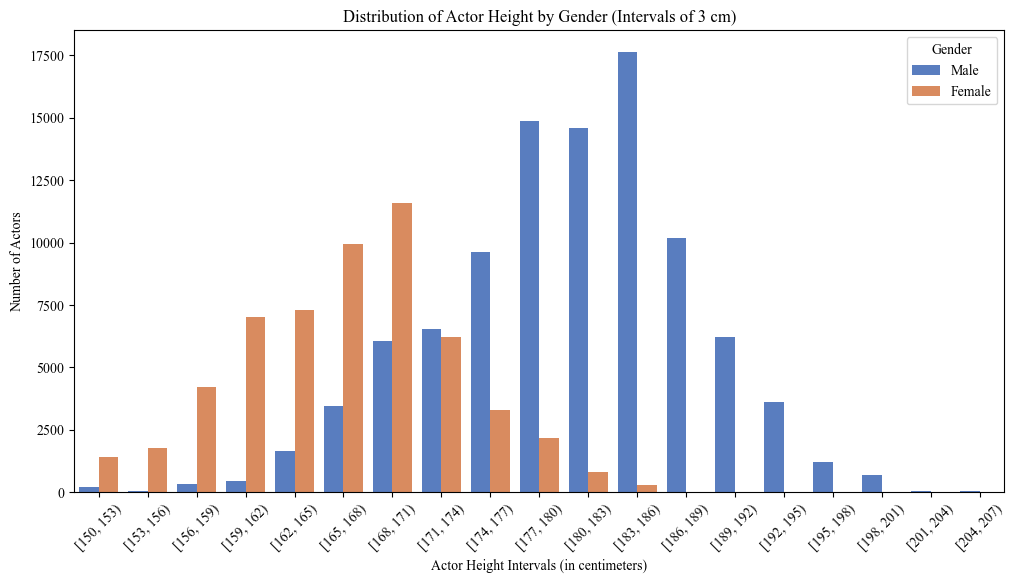

In [92]:
# Drop rows with missing values in 'actor_height' and 'actor_gender'
data_for_height_plot = characters.dropna(subset=['actor_height', 'actor_gender']).copy() 

# Convert height to centimeters and create height intervals in centimeters
data_for_height_plot.loc[:, 'actor_height_cm'] = data_for_height_plot['actor_height'] * 100

# Create height intervals in centimeters
data_for_height_plot.loc[:, 'height_intervals'] = pd.cut(data_for_height_plot['actor_height_cm'], bins=range(150, 210, 3), right=False)

# Set up the figure and axes
plt.figure(figsize=(12, 6))

# Create a countplot for height intervals with gender as hues
sns.countplot(x='height_intervals', hue='actor_gender', data=data_for_height_plot, palette='muted', hue_order=['M', 'F'], dodge=True)

# Set labels and title
plt.title('Distribution of Actor Height by Gender (Intervals of 3 cm)')
plt.xlabel('Actor Height Intervals (in centimeters)')
plt.ylabel('Number of Actors')
plt.xticks(rotation=45)

# Display the legend with specified labels
plt.legend(title='Gender', labels=['Male', 'Female'])

# Show the plot
plt.show()


In [94]:
# Drop rows with missing values in 'actor_ethnicity' and 'actor_gender'
data_for_ethnicity_plot = characters.dropna(subset=['actor_ethnicity', 'actor_gender'])

# Calculate the percentage distribution of each ethnicity
ethnicity_percentage = data_for_ethnicity_plot['actor_ethnicity'].value_counts(normalize=True) * 100

# Select the top 9 ethnicities
top_9_ethnicities = ethnicity_percentage.head(9)
top_9_ethnicities_series = pd.Series(top_9_ethnicities.values, index=top_9_ethnicities.index, name='Ethnicity Distribution')

# Apply convert_freebase_id_to_entity function to the index of top_10_ethnicities_series
converted_ethnicities = top_9_ethnicities_series.index.map(convert_freebase_id_to_entity)

# Create a new DataFrame with the converted ethnicities and their distribution percentages
top_9_actor_ethnicity = pd.DataFrame({'actor_ethnicity': converted_ethnicities, 'percentage_distribution': top_9_ethnicities_series})

# Display the new DataFrame
print(top_9_actor_ethnicity)


                    actor_ethnicity  percentage_distribution
actor_ethnicity                                             
/m/0dryh9k            Indian_people                15.423871
/m/0x67           African_Americans                 9.573535
/m/041rx                       Jews                 9.547122
/m/02w7gg            English_people                 5.815434
/m/033tf_           Irish_Americans                 3.638302
/m/0xnvg          Italian_Americans                 2.788390
/m/02ctzb              White_people                 2.175246
/m/07hwkr           White_Americans                 2.122421
/m/07bch9        Scottish_Americans                 2.096952


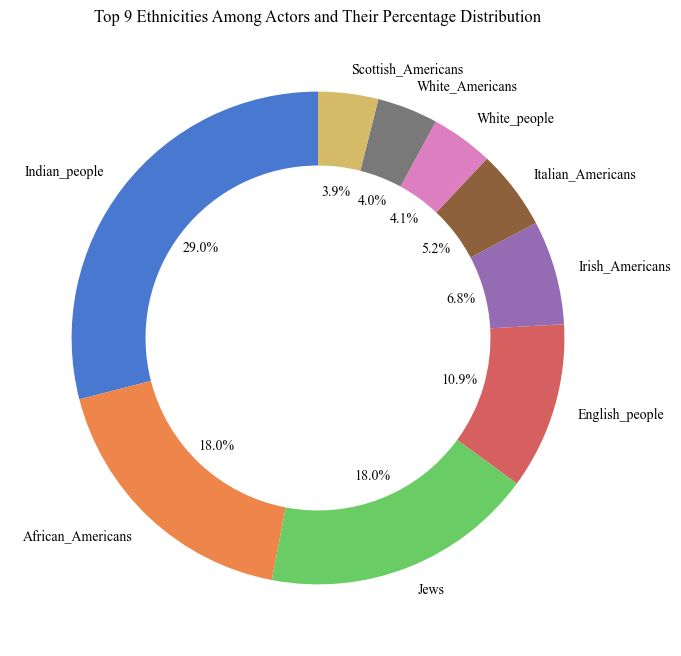

In [95]:
# Set up the figure and axes
plt.figure(figsize=(8, 8))

# Create a pie chart for the top 10 ethnicities
plt.pie(top_9_actor_ethnicity['percentage_distribution'], labels=top_9_actor_ethnicity['actor_ethnicity'],
        autopct='%1.1f%%', startangle=90, colors=sns.color_palette('muted'), wedgeprops=dict(width=0.3))

# Set labels and title
plt.title('Top 9 Ethnicities Among Actors and Their Percentage Distribution')

# Show the plot
plt.show()
